# To Do List
    => Data preprocessing (Loading data, loading to pytorch, normalizing, regulerization (Done)
    => Model Training with train dataloader and validation dataloader (Done)
    => Testing accuracy (Done)
    => Inference with real world data (Done)

*** Needs to adding COMMENTS for better readability of the code

In [1]:
import os

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available else "cpu"

In [2]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear = 10, scale = (0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

In [3]:
train = datasets.CIFAR10(
    root = './data',
    download = True,
    train = True,
    transform = None
)
test_dataset = datasets.CIFAR10(
    root = './data',
    download = True,
    train = False,
    transform = transform_val
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
val_size = 5000
train_size = len(train) - val_size
train_size

45000

In [5]:
train_data, val_data = random_split(train, [train_size, val_size])
len(train_data), len(val_data)

(45000, 5000)

In [6]:
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [7]:
train_dataset = MyDataset(train_data, transform = transform_train)
val_dataset = MyDataset(val_data, transform = transform_val)

In [8]:
class_names = test_dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

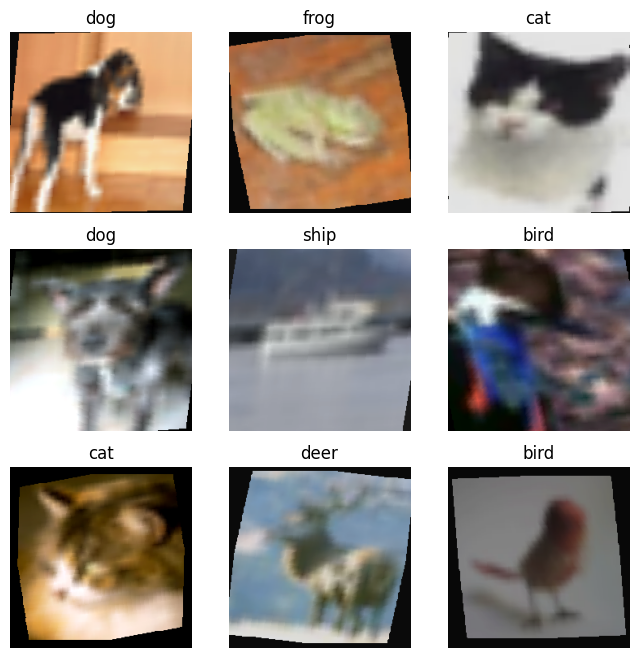

In [9]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    img = img / 2 + 0.5
    figure.add_subplot(rows, cols, i)
    plt.title(class_names[label])
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))
plt.show()

torch.Size([3, 224, 224])


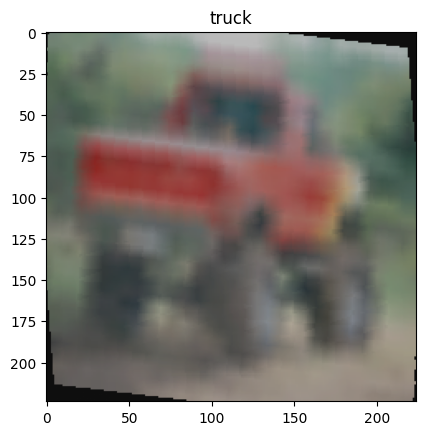

In [10]:
import random
random_idx = random.sample(list(range(len(train_dataset))), k = 1)
img, label = train_dataset[random_idx[0]]
img = img / 2 + 0.5 # remove normalization before visualization
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
print(img.shape)

In [11]:
BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, pin_memory = True)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE * 2, num_workers = NUM_WORKERS, pin_memory = True )
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE * 2, num_workers = NUM_WORKERS, pin_memory = True)

In [12]:
class Block(nn.Module): # This class is used for RenNet-18 and ResNet-34 only
    def __init__(self, in_channels, out_channels, identity_downsample = None, stride = 1):
        super().__init__()
        self.identity_downsample = identity_downsample
        self.stride = stride
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    def forward(self, x):
        shortcut = x.clone()
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.identity_downsample is not None:
            shortcut = self.identity_downsample(shortcut)
        out = out + shortcut
        out = self.relu(out)
        return out

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample = None, stride = 1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.expansion = 4
        self.identity_downsample = identity_downsample
        self.stride = stride
        self.conv1 = nn.Conv2d(self.in_channels, self.out_channels, kernel_size = 1, stride = stride, padding = 0, bias = False)
        self.bn1 = nn.BatchNorm2d(self.out_channels)
        self.conv2 = nn.Conv2d(self.out_channels, self.out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(self.out_channels)
        self.conv3 = nn.Conv2d(self.out_channels, self.out_channels * self.expansion, kernel_size = 1, stride = 1, padding = 0, bias = False)
        self.bn3 = nn.BatchNorm2d(self.out_channels * self.expansion)
        self.relu = nn.ReLU()
    def forward(self, x):
        shortcut = x.clone()
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.identity_downsample is not None:
            shortcut = self.identity_downsample(shortcut)
        out = out + shortcut
        out = self.relu(out)
        return out

In [14]:
# Trying to make it universal for all ResNet architecture!
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super().__init__()
        self.in_channels = 64
        self.expansion = 4
        if block != ResidualBlock:
            self.expansion = 1
        self.layers = layers
        self.image_channels = image_channels
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(self.image_channels, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer1 = self._make_layer(block, layers[0], out_channels = 64, stride = 1)
        self.layer2 = self._make_layer(block, layers[1], out_channels = 128, stride = 2)
        self.layer3 = self._make_layer(block, layers[2], out_channels = 256, stride = 2)
        self.layer4 = self._make_layer(block, layers[3], out_channels = 512, stride = 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, self.num_classes)
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out
    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []
        if block != ResidualBlock:
            if stride != 1:
                identity_downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, self.in_channels * 2, kernel_size = 1, stride = stride, bias = False),
                    nn.BatchNorm2d(self.in_channels * 2),
                )
        else:
            if stride != 1 or self.in_channels != out_channels*4:
                identity_downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, out_channels * 4, kernel_size = 1, stride = stride, bias = False),
                    nn.BatchNorm2d(out_channels * 4),
                )
        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        if block != ResidualBlock:
            self.in_channels = out_channels
        else:
            self.in_channels = out_channels * 4
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

In [15]:
resnet18 = ResNet(Block, [2, 2, 2, 2], 3, 10)
resnet34 = ResNet(Block, [3, 4, 6, 3], 3, 10)
resnet50 = ResNet(ResidualBlock, [3, 4, 6, 3], 3, 10).to(device)
resnet101 = ResNet(ResidualBlock, [3, 4, 23, 3], 3, 10)
resnet152 = ResNet(ResidualBlock, [3, 8, 36, 3], 3, 10)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr = 0.001)

In [18]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
for epoch in range(epochs):
    train_size = len(train_dataloader.dataset)
    train_len = len(train_dataloader)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    resnet50.train()
    train_loss, train_correct = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        # Compute prediction and loss

        X, y = X.to(device), y.to(device)
        pred = resnet50(X)
        loss = criterion(pred, y)
        train_loss += loss.item()
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{train_size:>5d}]")
    train_loss /= train_len
    train_correct /= train_size
    running_loss_history.append(train_loss)
    running_corrects_history.append(train_correct)

    resnet50.eval()
    size = len(val_dataloader.dataset)
    num_batches = len(val_dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = resnet50(X)
            test_loss += criterion(test_pred, y).item()
            correct += (test_pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    val_running_loss_history.append(test_loss)
    val_running_corrects_history.append(correct)

    print(f"Epoch : {epoch+1}")
    print(f"Training accuracy: {(100*train_correct):>0.1f}%, Avg training loss: {train_loss:>8f}")
    print(f"Validation accuracy: {(100*correct):>0.1f}%, Avg validation loss: {test_loss:>8f} \n")

loss: 2.513243  [  128/45000]
loss: 1.899061  [12928/45000]
loss: 1.676221  [25728/45000]
loss: 1.552504  [38528/45000]
Epoch : 1
Training accuracy: 32.7%, Avg training loss: 1.833788
Validation accuracy: 39.1%, Avg validation loss: 1.881034 

loss: 1.651906  [  128/45000]
loss: 1.478672  [12928/45000]
loss: 1.379488  [25728/45000]
loss: 1.314282  [38528/45000]
Epoch : 2
Training accuracy: 49.6%, Avg training loss: 1.377233
Validation accuracy: 56.5%, Avg validation loss: 1.218270 

loss: 1.134054  [  128/45000]
loss: 1.248094  [12928/45000]
loss: 1.182227  [25728/45000]
loss: 0.921666  [38528/45000]
Epoch : 3
Training accuracy: 61.5%, Avg training loss: 1.071612
Validation accuracy: 65.8%, Avg validation loss: 0.968387 

loss: 0.879005  [  128/45000]
loss: 0.885340  [12928/45000]
loss: 0.822630  [25728/45000]
loss: 0.831560  [38528/45000]
Epoch : 4
Training accuracy: 68.0%, Avg training loss: 0.905469
Validation accuracy: 72.2%, Avg validation loss: 0.824813 

loss: 0.806521  [  128/4

In [19]:
resnet50.eval()
size = len(test_dataloader.dataset)
num_batches = len(test_dataloader)
test_loss, correct = 0, 0

# Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
# also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = resnet50(X)
        test_loss += criterion(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

test_loss /= num_batches
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Test Error: 
 Accuracy: 85.6%, Avg loss: 0.444670 



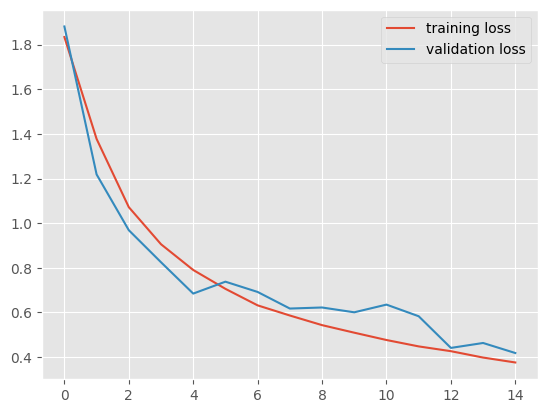

In [20]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

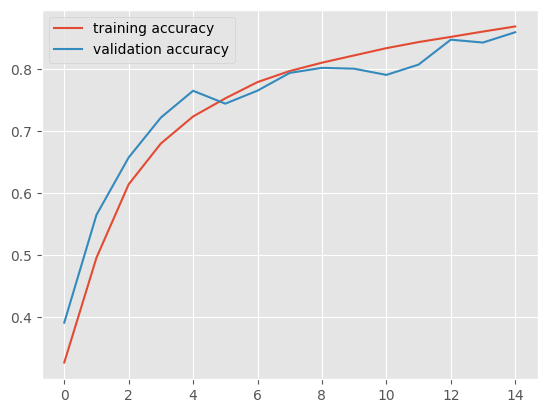

In [21]:
plt.style.use('ggplot')
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

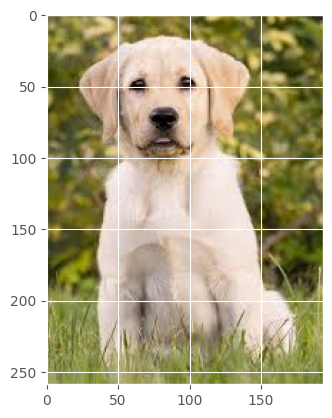

In [61]:
import PIL.ImageOps
import requests
from PIL import Image

url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcT76mSMtKQWGstcqGi-0kPWJyVBqz8RCp8SuplMipkidRY0z9Mc&usqp=CAU'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

In [62]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

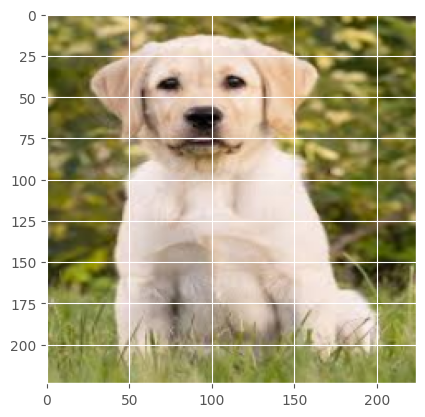

In [63]:
img = transform_val(img)  # applying the transformations on new image as our model has been trained on these transformations
plt.imshow(im_convert(img)) # convert to numpy array for plt

In [64]:
image = img.to(device).unsqueeze(0) # put inputs in device as our model is running there
output = resnet50(image)
_, pred = torch.max(output, 1)
print(class_names[pred.item()])

dog


In [66]:
torch.save(resnet50.state_dict(), 'cifar10_trained_parameters_on_ResNet50.pth')